# MiniProject 2: Optimization and Text Classification
## COMP 551, Fall 2021, McGill University
### October 7, 2021
### Benslimane, Saad & Stappas, Oliver & Yahyaei, Mohsen

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.core.debugger import set_trace
import warnings
import nltk
from sklearn.metrics import accuracy_score as accuracy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.utils import shuffle
%matplotlib inline
warnings.filterwarnings('ignore')

In [48]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function

In [49]:
def cost_fn(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

In [50]:
def gradient(self, x, y, delta_w=0):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))                           # predictions  size N
    grad = np.dot(x.T, yh - y)/N                               # divide by N because cost is mean over N points
    delta_w = self.beta * delta_w + (1 - self.beta) * grad
    return delta_w                                             # size D

In [51]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, beta=0, epsilon=1e-4, max_iters=1e5, verbose=False, batchSize=0):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.batchSize=batchSize
        self.beta = beta
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        delta_w = np.zeros(self.w.shape)
        g = np.inf
        t = 0
        #costt=[]
        #itera=[]
        # the code snippet below is for gradient descent
        #f,ax = plt.subplots(figsize = (20, 10))
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            if self.batchSize==0: #Full Batch
                g = self.gradient(x, y, delta_w)
                self.w = self.w - self.learning_rate * g 
                #itera.append(t)
                t += 1
                #costt.append(cost_fn(x, y, self.w))
                #plt.plot(itera, costt)
            else:
                ind = np.random.permutation(N)
                for j in range(0, N-self.batchSize,self.batchSize):
                    xBatch,yBatch=[],[]
                    inds = ind[j:j+self.batchSize]
                    xBatch = x.iloc[inds, :]
                    yBatch = y.iloc[inds]
                    g = self.gradient(xBatch, yBatch, delta_w)
                    self.w = self.w - self.learning_rate * g 
                    #itera.append(t)
                    t += 1
                    #costt.append(cost_fn(x, y, self.w))
                    #plt.plot(itera, costt)
                    if t == self.max_iters:
                        break
        #plt.xlabel("Iteration", fontsize=20)
        #plt.ylabel("Cost", fontsize=20)
        #plt.legend()
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self,self.w
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

LogisticRegression.gradient = gradient  #initialize the gradient method of the LogisticRegression class with gradient function

## Question 1 :

### Load datasets :

In [52]:
train = pd.read_csv("data_A2\diabetes\diabetes_train.csv")
x_train= train.iloc[:, train.columns != 'Outcome'].iloc[:, 0:]
y_train= train['Outcome']
print("Size of train dataset : ", x_train.shape)

validation = pd.read_csv("data_A2\diabetes\diabetes_val.csv")
x_validation = validation.iloc[:, validation.columns != 'Outcome'].iloc[:, 0:]
y_validation = validation['Outcome']
print("Size of validation dataset : ", x_validation.shape)

test = pd.read_csv("data_A2\diabetes\diabetes_test.csv")
x_test = test.iloc[:, test.columns != 'Outcome'].iloc[:, 0:]
y_test=test['Outcome']
print("Size of test dataset : ", x_test.shape)

Size of train dataset :  (600, 8)
Size of validation dataset :  (100, 8)
Size of test dataset :  (68, 8)


In [53]:
train.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            5      144             82             26      285  32.0   
1            0      128             68             19      180  30.5   
2            9      156             86             28      155  34.3   
3            1      144             82             46      180  46.1   
4            0      179             90             27        0  44.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.452   58        1  
1                     1.391   25        1  
2                     1.189   42        1  
3                     0.335   46        1  
4                     0.686   23        1

### The best learning rate :

In machine machine learning and statistics, the learning rate is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function.

In this part we are going to search for the best vaue of learning rate that helps our model Logistic regression to fully converge to a solution. We are going to fixe the number of iterations in 10 000 iterations.

In [54]:
results_lr = {"learning_rate" :[],
              "acc_train" :[], 
              "acc_val" :[],
              "cost" :[],
              "time" :[]}

learning_rates = list(np.arange(0.00001, 0.001, 0.00001))

for i in learning_rates:   
    start = time.time()
    print ("learning rate is: " + str(round(i,5)))
    model = LogisticRegression(add_bias=False, verbose=True, learning_rate=round(i,5), max_iters=10000)
    x11=[]
    x11,weight = model.fit(x_train,y_train)
    results_lr["time"].append((time.time() - start))
    yhat_train = x11.predict(x_train)
    yhat_val = x11.predict(x_validation)
    results_lr["learning_rate"].append(round(i,5))
    results_lr["acc_val"].append(accuracy(np.round(yhat_val),y_validation))
    results_lr["acc_train"].append(accuracy(np.round(yhat_train),y_train))
    results_lr["cost"].append(cost_fn(x_train, y_train, weight))
    print ("-------------------------------------------------------")


learning rate is: 1e-05
terminated after 10000 iterations, with norm of the gradient equal to 0.18781438971876782
the weight found: [ 0.02109906  0.01230528 -0.03027452 -0.00154364  0.0014588  -0.00557884
  0.00050829  0.00435068]
-------------------------------------------------------
learning rate is: 2e-05
terminated after 10000 iterations, with norm of the gradient equal to 0.1560121480677105
the weight found: [ 0.03803335  0.01238366 -0.03063141 -0.00103768  0.0014694  -0.00599357
  0.0010723   0.00281576]
-------------------------------------------------------
learning rate is: 3e-05
terminated after 10000 iterations, with norm of the gradient equal to 0.13212123590520786
the weight found: [ 0.05222151  0.01252464 -0.03063083 -0.00097973  0.00148656 -0.00611163
  0.00165875  0.00061413]
-------------------------------------------------------
learning rate is: 4e-05
terminated after 10000 iterations, with norm of the gradient equal to 0.11201943427201944
the weight found: [ 0.0642

terminated after 10000 iterations, with norm of the gradient equal to 27.27780902444977
the weight found: [ 0.14591734  0.01713362 -0.03222501 -0.00191988  0.00494613 -0.00628594
  0.02002704 -0.01238338]
-------------------------------------------------------
learning rate is: 0.00031
terminated after 10000 iterations, with norm of the gradient equal to 31.162180116031816
the weight found: [ 0.15162013  0.01802857 -0.03289913 -0.00227576  0.00562875 -0.00654727
  0.02065347 -0.01262808]
-------------------------------------------------------
learning rate is: 0.00032
terminated after 10000 iterations, with norm of the gradient equal to 34.42342836591345
the weight found: [ 0.15760862  0.01890712 -0.03362287 -0.00263003  0.00626635 -0.0068384
  0.02125421 -0.01292322]
-------------------------------------------------------
learning rate is: 0.00033
terminated after 10000 iterations, with norm of the gradient equal to 37.22457892992899
the weight found: [ 0.16384032  0.01977609 -0.03438

terminated after 10000 iterations, with norm of the gradient equal to 60.762623952958144
the weight found: [ 0.35117673  0.04041407 -0.05912033 -0.01141387  0.01928672 -0.01731149
  0.03563464 -0.02571702]
-------------------------------------------------------
learning rate is: 0.0006
terminated after 10000 iterations, with norm of the gradient equal to 61.025908633408726
the weight found: [ 0.35833438  0.04112845 -0.06011362 -0.01170177  0.01970317 -0.01764427
  0.03616157 -0.0262073 ]
-------------------------------------------------------
learning rate is: 0.00061
terminated after 10000 iterations, with norm of the gradient equal to 61.27333361500361
the weight found: [ 0.36545645  0.04183708 -0.06110582 -0.01198671  0.02011611 -0.01796816
  0.03668986 -0.02669455]
-------------------------------------------------------
learning rate is: 0.00062
terminated after 10000 iterations, with norm of the gradient equal to 61.50610383773678
the weight found: [ 0.37254162  0.04254    -0.0620

terminated after 10000 iterations, with norm of the gradient equal to 64.67762441572278
the weight found: [ 0.54101496  0.0589922  -0.0871344  -0.01861351  0.02987127 -0.02311227
  0.05161936 -0.03833267]
-------------------------------------------------------
learning rate is: 0.00089
terminated after 10000 iterations, with norm of the gradient equal to 64.73851116892472
the weight found: [ 0.5468152   0.05956089 -0.08806279 -0.01882073  0.03017694 -0.02317048
  0.05219381 -0.03869868]
-------------------------------------------------------
learning rate is: 0.0009
terminated after 10000 iterations, with norm of the gradient equal to 64.79695577495414
the weight found: [ 0.55256144  0.06012524 -0.08898835 -0.01902526  0.03047836 -0.02321974
  0.05276912 -0.03905966]
-------------------------------------------------------
learning rate is: 0.00091
terminated after 10000 iterations, with norm of the gradient equal to 64.85308270811615
the weight found: [ 0.55825353  0.06068527 -0.089911

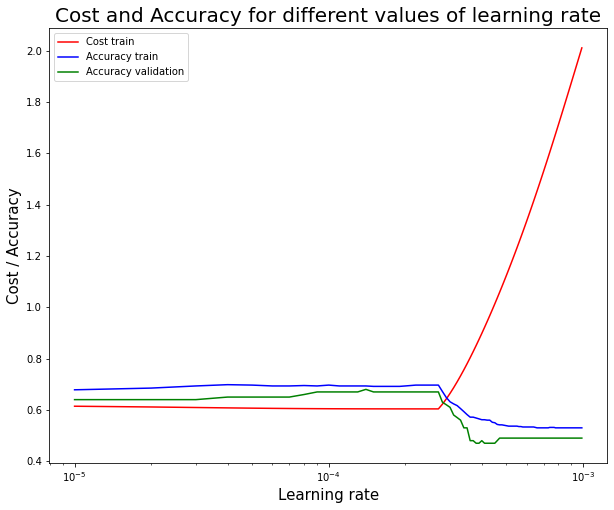

In [55]:
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_lr["learning_rate"], results_lr["cost"], color="red", label="Cost train")
plt.plot(results_lr["learning_rate"], results_lr["acc_train"], color="blue", label="Accuracy train")
plt.plot(results_lr["learning_rate"], results_lr["acc_val"], color="green", label="Accuracy validation")
plt.xscale("log")
plt.title("Cost and Accuracy for different values of learning rate", fontsize = 20)
plt.xlabel("Learning rate", fontsize=15)
plt.ylabel("Cost / Accuracy", fontsize=15)
plt.legend()

#### The best learning rate based on the minimum cost value :

In [56]:
for i in range(len(learning_rates)) :
    if results_lr["cost"][i] == min(results_lr["cost"]):
        print("Index:",i)        
        print("Accuracy train:",round(results_lr["acc_train"][i], 3))
        print("Accuracy validation:",results_lr["acc_val"][i])
        print("Cost:",round(results_lr["cost"][i], 3))        
        print("Learning rate:",round(results_lr["learning_rate"][i], 5))       
        print("Time train (s):",results_lr["time"][i])

Index: 26
Accuracy train: 0.697
Accuracy validation: 0.67
Cost: 0.604
Learning rate: 0.00027
Time train (s): 4.163720607757568


#### The best learning rate based on the maximum accuracy value :

In [57]:
for i in range(len(learning_rates)) :
    if results_lr["acc_val"][i] == max(results_lr["acc_val"]):
        print("Index:",i)        
        print("Accuracy train:",round(results_lr["acc_train"][i], 3))
        print("Accuracy validation:",results_lr["acc_val"][i])
        print("Cost:",round(results_lr["cost"][i], 3))        
        print("Learning rate:",round(results_lr["learning_rate"][i], 5))       
        print("Time train (s):",results_lr["time"][i])

Index: 13
Accuracy train: 0.693
Accuracy validation: 0.68
Cost: 0.604
Learning rate: 0.00014
Time train (s): 4.17572283744812


In this section we've tried multiple values of learning rate (between 0.00001 and 0.001) with a maximum iterations of 10 000, and from the graph we can see that, for learning rates larger than 0.00027, the accuracy of the model decreases (for both training and validation datasets) and the cost function increases (for training sets).

For the rest of the exercise we're going to work with a learning rate equal to 0.00014 to have an optimum result.

### The number of iterations :

Now that we found the best value of learning rate, we are going to try multiple value of max iterations, with a step of 100 iterations, to found the optimum value of max iteration.

In [58]:
results_itr = {"Nbr_Iteration" :[],
               "acc_train" :[],
               "acc_val" :[],
               "cost" :[],
               "time" :[]}

for i in range(200):
    start = time.time()
    results_itr["Nbr_Iteration"].append((i+1)*5)
    model = LogisticRegression(add_bias=False, verbose=True, learning_rate=0.00014, max_iters=(i+1)*5)
    x11=[]
    x11,weight = model.fit(x_train,y_train)
    results_itr["time"].append((time.time() - start))
    yhat_train = x11.predict(x_train)
    yhat_val = x11.predict(x_validation)
    results_itr["acc_train"].append(accuracy(np.round(yhat_train),y_train))
    results_itr["acc_val"].append(accuracy(np.round(yhat_val),y_validation))
    results_itr["cost"].append(cost_fn(x_train, y_train, weight))
    print ("-------------------------------------------------------")


terminated after 5 iterations, with norm of the gradient equal to 3.756872317959828
the weight found: [ 4.98932774e-05 -1.43883594e-03 -3.35861792e-03 -7.74272950e-04
  1.37641934e-03 -1.00367839e-03 -8.20741536e-06 -8.24786191e-04]
-------------------------------------------------------
terminated after 10 iterations, with norm of the gradient equal to 2.8751702154063197
the weight found: [ 1.88889153e-04 -6.91424607e-04 -5.22386297e-03 -1.25310520e-03
  1.81578573e-03 -1.37772540e-03 -8.26665635e-06 -9.47574460e-04]
-------------------------------------------------------
terminated after 15 iterations, with norm of the gradient equal to 2.6164935758921253
the weight found: [ 3.41095653e-04  2.32152056e-04 -6.79484136e-03 -1.66927321e-03
  1.88685478e-03 -1.65601305e-03 -7.23435423e-06 -9.71637593e-04]
-------------------------------------------------------
terminated after 20 iterations, with norm of the gradient equal to 2.4073224480743414
the weight found: [ 4.97030577e-04  1.12700

-------------------------------------------------------
terminated after 150 iterations, with norm of the gradient equal to 0.47677963210597296
the weight found: [ 4.71459970e-03  1.06216477e-02 -2.42726444e-02 -4.43667254e-03
  1.62103613e-03 -4.51150406e-03  7.22181693e-05  6.18103349e-04]
-------------------------------------------------------
terminated after 155 iterations, with norm of the gradient equal to 0.45844252251060547
the weight found: [ 4.87630889e-03  1.07391023e-02 -2.45153598e-02 -4.41539570e-03
  1.61550079e-03 -4.54737498e-03  7.59018975e-05  6.92953298e-04]
-------------------------------------------------------
terminated after 160 iterations, with norm of the gradient equal to 0.44157314166887596
the weight found: [ 5.03776964e-03  1.08487562e-02 -2.47456354e-02 -4.39145178e-03
  1.61015458e-03 -4.58119747e-03  7.96050447e-05  7.67455329e-04]
-------------------------------------------------------
terminated after 165 iterations, with norm of the gradient equal 

terminated after 310 iterations, with norm of the gradient equal to 0.2517729944447308
the weight found: [ 0.00974089  0.01219301 -0.02836616 -0.00325423  0.00151099 -0.00509488
  0.00019481  0.00266274]
-------------------------------------------------------
terminated after 315 iterations, with norm of the gradient equal to 0.24970724849343132
the weight found: [ 0.00989266  0.01220539 -0.02842621 -0.00321651  0.0015091  -0.00510391
  0.0001987   0.00271212]
-------------------------------------------------------
terminated after 320 iterations, with norm of the gradient equal to 0.247731950740948
the weight found: [ 0.0100441   0.01221685 -0.02848417 -0.00317923  0.00150726 -0.00511273
  0.00020259  0.00276058]
-------------------------------------------------------
terminated after 325 iterations, with norm of the gradient equal to 0.24584066363109802
the weight found: [ 0.01019523  0.01222746 -0.02854015 -0.00314239  0.00150549 -0.00512135
  0.00020648  0.00280812]
---------------

-------------------------------------------------------
terminated after 470 iterations, with norm of the gradient equal to 0.21178763390912952
the weight found: [ 0.01444454  0.01232999 -0.02959057 -0.00228205  0.00147304 -0.00532146
  0.00031907  0.00382208]
-------------------------------------------------------
terminated after 475 iterations, with norm of the gradient equal to 0.21103563628649916
the weight found: [ 0.01458673  0.01233006 -0.02961374 -0.00225927  0.00147239 -0.00532741
  0.00032294  0.00384576]
-------------------------------------------------------
terminated after 480 iterations, with norm of the gradient equal to 0.2103009102386215
the weight found: [ 0.01472864  0.01233004 -0.02963634 -0.00223689  0.00147177 -0.00533333
  0.00032682  0.00386879]
-------------------------------------------------------
terminated after 485 iterations, with norm of the gradient equal to 0.20958284388946302
the weight found: [ 0.01487028  0.01232994 -0.02965838 -0.00221492  0.0014

terminated after 630 iterations, with norm of the gradient equal to 0.19400410569303111
the weight found: [ 0.01886763  0.0123132  -0.03011704 -0.001726    0.00146079 -0.00549715
  0.00044296  0.00429422]
-------------------------------------------------------
terminated after 635 iterations, with norm of the gradient equal to 0.19359673105424322
the weight found: [ 0.0190019   0.01231259 -0.03012819 -0.00171339  0.00146061 -0.0055022
  0.00044683  0.00430085]
-------------------------------------------------------
terminated after 640 iterations, with norm of the gradient equal to 0.19319547096761092
the weight found: [ 0.01913594  0.01231199 -0.0301391  -0.001701    0.00146043 -0.00550722
  0.00045071  0.00430707]
-------------------------------------------------------
terminated after 645 iterations, with norm of the gradient equal to 0.1928001415090099
the weight found: [ 0.01926976  0.0123114  -0.03014979 -0.00168884  0.00146027 -0.00551221
  0.00045458  0.00431288]
--------------

terminated after 790 iterations, with norm of the gradient equal to 0.18326564081960414
the weight found: [ 0.02305888  0.01230208 -0.03038006 -0.00141726  0.00145823 -0.00564555
  0.00056712  0.00433179]
-------------------------------------------------------
terminated after 795 iterations, with norm of the gradient equal to 0.18298594551950736
the weight found: [ 0.02318654  0.01230203 -0.03038581 -0.00141017  0.00145823 -0.00564975
  0.00057101  0.00432809]
-------------------------------------------------------
terminated after 800 iterations, with norm of the gradient equal to 0.1827086227800832
the weight found: [ 0.02331401  0.01230201 -0.03039143 -0.00140321  0.00145823 -0.00565392
  0.00057491  0.00432414]
-------------------------------------------------------
terminated after 805 iterations, with norm of the gradient equal to 0.18243360620456392
the weight found: [ 0.02344129  0.012302   -0.03039695 -0.00139637  0.00145824 -0.00565806
  0.0005788   0.00431995]
-------------

terminated after 950 iterations, with norm of the gradient equal to 0.17522572361186253
the weight found: [ 0.02705374  0.01230872 -0.03051602 -0.00124152  0.00145947 -0.00576682
  0.00069206  0.00411136]
-------------------------------------------------------
terminated after 955 iterations, with norm of the gradient equal to 0.174997291215549
the weight found: [ 0.0271757   0.01230915 -0.03051898 -0.00123742  0.00145954 -0.00577018
  0.00069598  0.00410166]
-------------------------------------------------------
terminated after 960 iterations, with norm of the gradient equal to 0.17476987204047795
the weight found: [ 0.0272975   0.01230961 -0.03052187 -0.00123338  0.00145961 -0.00577353
  0.0006999   0.00409182]
-------------------------------------------------------
terminated after 965 iterations, with norm of the gradient equal to 0.1745434418389616
the weight found: [ 0.02741913  0.01231007 -0.03052471 -0.00122941  0.00145969 -0.00577685
  0.00070383  0.00408185]
---------------

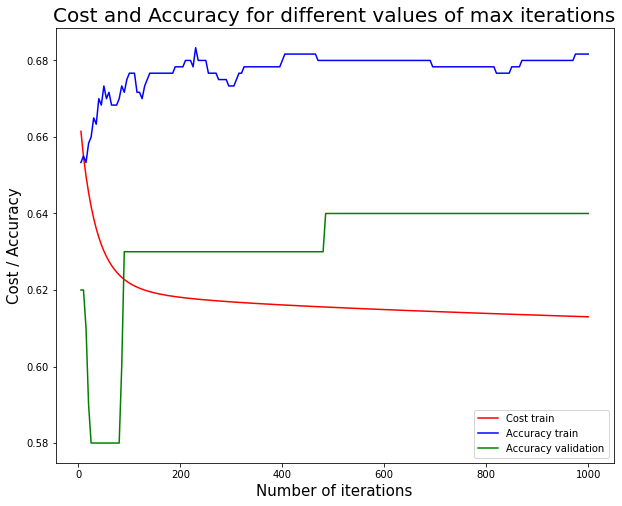

In [59]:
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_itr["Nbr_Iteration"], results_itr["cost"], color="red", label="Cost train")
plt.plot(results_itr["Nbr_Iteration"], results_itr["acc_train"], color="blue", label="Accuracy train")
plt.plot(results_itr["Nbr_Iteration"], results_itr["acc_val"], color="green", label="Accuracy validation")
plt.title("Cost and Accuracy for different values of max iterations", fontsize = 20)
plt.xlabel("Number of iterations", fontsize=15)
plt.ylabel("Cost / Accuracy", fontsize=15)
plt.legend()

Text(0, 0.5, 'Time')

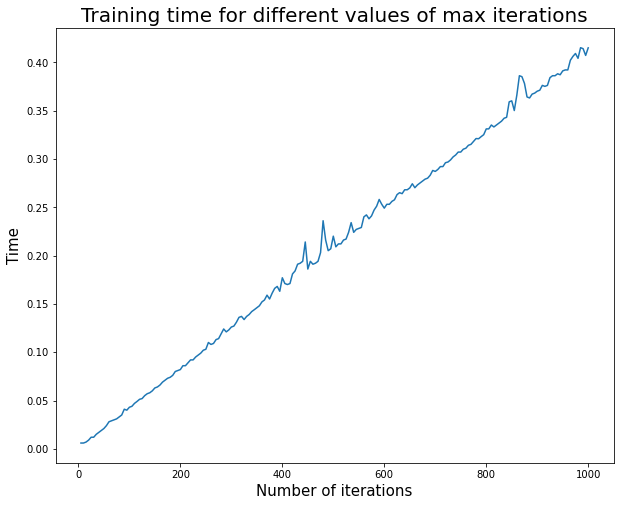

In [60]:
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_itr["Nbr_Iteration"], results_itr["time"])
plt.title("Training time for different values of max iterations", fontsize = 20)
plt.xlabel("Number of iterations", fontsize=15)
plt.ylabel("Time", fontsize=15)

After we fixed the learning rate at 0.00014, we've run the model for multiple values of maximum iterations (until 1000 iteration with a step of 5 each time) to see for wich value the model converge to a solution.

From the graph we can see that the model start converging to a solution from 500 iterations, and the time of training increases with the number of iterations. So for the rest of this exercise we're going to use a number of maximum iterations equal to 500.

## Question 2 :

In machine learning, the batch size is the number of items we take from the data during training. If we use the batch size of one we update weights after every sample. in other words, if we use batch size 32, we calculate the average error and then update weights every 32 items.

In this part, we'll try several values of mini-batch size to compare the convergence speed and quality of the solution.

https://androidkt.com/batch-size-step-iteration-epoch-neural-network/

In [61]:
results_batch = {"Batch_size" :[0, 1, 8, 16, 32, 64, 128, 256, 512],
               "acc_train" :[],
               "acc_val" :[],
               "cost" :[],
               "time" :[]
                }

for i in results_batch["Batch_size"]:
    start = time.time()
    model = LogisticRegression(add_bias=False, verbose=True, learning_rate=0.00014, max_iters=500, batchSize=i)
    x11=[]
    x11,weight = model.fit(x_train,y_train)
    results_batch["time"].append((time.time() - start))
    yhat_train = x11.predict(x_train)
    yhat_val = x11.predict(x_validation)
    results_batch["acc_train"].append(accuracy(np.round(yhat_train),y_train))
    results_batch["acc_val"].append(accuracy(np.round(yhat_val),y_validation))
    results_batch["cost"].append(cost_fn(x_train, y_train, weight))
    print ("-------------------------------------------------------")


terminated after 500 iterations, with norm of the gradient equal to 0.20752290193613335
the weight found: [ 0.01529361  0.01232922 -0.02972133 -0.00215136  0.00146949 -0.00535666
  0.00034231  0.00395445]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 0.243283400246106
the weight found: [ 0.01765071  0.04605497 -0.05720688  0.00325093  0.01559401 -0.00894162
  0.0004841   0.00468153]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 23.940204668138627
the weight found: [ 0.01669282  0.00801466 -0.03593609 -0.00516223 -0.0026035  -0.00900832
  0.0002817   0.00539043]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 52.59421510516461
the weight found: [ 0.01483551  0.00990861 -0.03243271 -0.0032465  -0.0031565  -0.00546372
  0.00034915  0.00287122]
-----------------

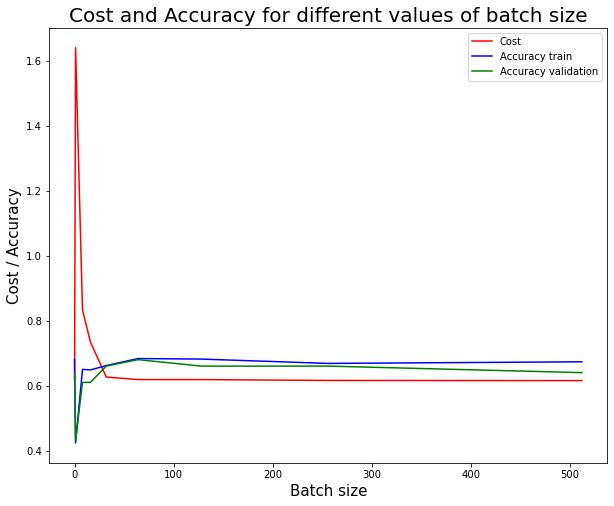

In [62]:
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_batch["Batch_size"], results_batch["cost"], color="red", label="Cost")
plt.plot(results_batch["Batch_size"], results_batch["acc_train"], color="blue", label="Accuracy train")
plt.plot(results_batch["Batch_size"], results_batch["acc_val"], color="green", label="Accuracy validation")
plt.title("Cost and Accuracy for different values of batch size", fontsize = 20)
plt.xlabel("Batch size", fontsize=15)
plt.ylabel("Cost / Accuracy", fontsize=15)
plt.legend()

In [63]:
for i in range(len(results_batch["Batch_size"])) :
    if results_batch["acc_val"][i] == max(results_batch["acc_val"]):
        print("Index:",i)        
        print("Accuracy train:",results_batch["acc_train"][i])
        print("Accuracy validation:",results_batch["acc_val"][i])
        print("Cost:",results_batch["cost"][i])        
        print("Batch size:",results_batch["Batch_size"][i])       
        print("Time (s):",results_batch["time"][i])
        print ("-------------------------------------------------------")

Index: 5
Accuracy train: 0.6833333333333333
Accuracy validation: 0.68
Cost: 0.6186287958256637
Batch size: 64
Time (s): 0.2950606346130371
-------------------------------------------------------


Text(0, 0.5, 'Time')

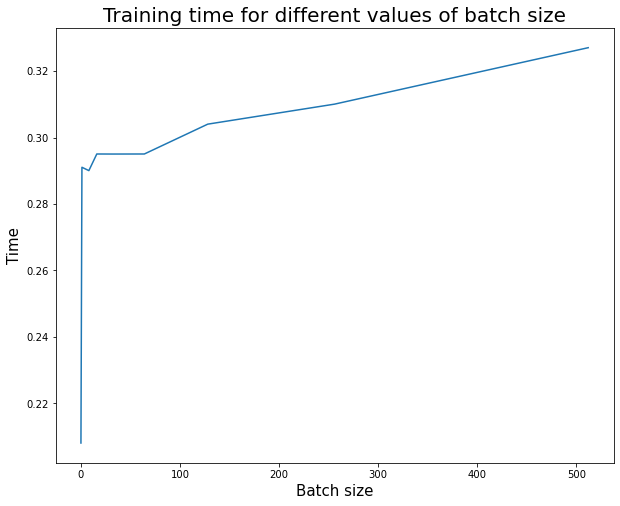

In [64]:
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_batch["Batch_size"], results_batch["time"])
plt.title("Training time for different values of batch size", fontsize = 20)
plt.xlabel("Batch size", fontsize=15)
plt.ylabel("Time", fontsize=15)

In this step we've implemented the mini-batch stocastic gradient descent, and we executed the model (with a learning rate of 0.00014 and a maximum iterations of 500) for multiple values of the batch size (from 8 to 512 and 0 for the fully batched).

We can see from the results we get that the model reach his maximum accuracy for a batch size of 16 each step, but converge to a solution from the value of 128 batch (or more) where the quality of the solution becomes stable (for train and validation datasets) while the speed of convergence increases with the number of batch size.

## Question 3 :

###  The gradient descent with momentum :

Momentum is an extension to the gradient descent optimization algorithm that allows the search to build inertia in a direction in the search space and overcome the oscillations of noisy gradients and coast across flat spots of the search space.

In this part, we've added momentum to the gradient descent implementation and we'll try multiple values of the momentum coefficient and see the impact of momentum on the convergence speed and quality.

https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/

In [65]:
results_beta = {"beta" :list(np.arange(0, 1.0, 0.01)),
               "acc_train" :[],
               "acc_val" :[],
               "cost" :[],
               "time" :[]}


for i in results_beta["beta"]:
    start = time.time()
    model = LogisticRegression(add_bias=False, verbose=True, learning_rate=0.00014, max_iters=500, batchSize=128, beta=i)
    x11=[]
    x11,weight = model.fit(x_train,y_train)
    results_beta["time"].append((time.time() - start))
    yhat_train = x11.predict(x_train)
    yhat_val = x11.predict(x_validation)
    results_beta["acc_train"].append(accuracy(np.round(yhat_train),y_train))
    results_beta["acc_val"].append(accuracy(np.round(yhat_val),y_validation))
    results_beta["cost"].append(cost_fn(x_train, y_train, weight))
    print ("-------------------------------------------------------")


terminated after 500 iterations, with norm of the gradient equal to 7.4931815339370464
the weight found: [ 0.01539887  0.01247504 -0.03009025 -0.00217101  0.0012539  -0.0054389
  0.00035846  0.00372566]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 10.464641292573852
the weight found: [ 0.01542982  0.0117457  -0.03027439 -0.00204439  0.00053236 -0.00560214
  0.00032792  0.00420825]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 8.366509325942387
the weight found: [ 0.01512686  0.01338214 -0.02960502 -0.00204406  0.00238024 -0.00513218
  0.00035446  0.0037861 ]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 3.719858399290782
the weight found: [ 0.01497112  0.01257537 -0.03066183 -0.00214867  0.00154636 -0.00565939
  0.00033912  0.00467741]
-------------------

terminated after 500 iterations, with norm of the gradient equal to 1.2256843059654845
the weight found: [ 0.0106436   0.01208722 -0.02858293 -0.00292671  0.00240077 -0.00510069
  0.00023755  0.00306682]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 2.12088311588318
the weight found: [ 0.01042603  0.01200812 -0.02887266 -0.00310057  0.00085598 -0.00488252
  0.00020894  0.00265679]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 6.43441174239589
the weight found: [ 0.01040033  0.01265594 -0.02878726 -0.00322786  0.0021018  -0.00504368
  0.00020501  0.00268222]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 1.2025133877458096
the weight found: [ 0.01013982  0.01251494 -0.02851187 -0.00304251  0.00192446 -0.00536956
  0.0002207   0.00290816]
--------------------

terminated after 500 iterations, with norm of the gradient equal to 4.8381234538069915
the weight found: [ 5.76158123e-03  1.09944433e-02 -2.52964633e-02 -4.41578680e-03
  1.78541314e-03 -4.69061193e-03  9.69119232e-05  8.79626683e-04]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 4.247330865419869
the weight found: [ 5.49364197e-03  1.12988470e-02 -2.54603464e-02 -4.23681354e-03
  1.83471333e-03 -4.67497890e-03  7.50050303e-05  7.87787959e-04]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 1.6025305441902442
the weight found: [ 5.36594888e-03  1.10055771e-02 -2.53671132e-02 -4.29362375e-03
  1.71706338e-03 -4.63651756e-03  9.16698012e-05  8.97560171e-04]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 4.7148993734474836
the weight found: [ 5.24863732e-03  1.

terminated after 500 iterations, with norm of the gradient equal to 0.437740303713533
the weight found: [ 9.82994944e-04  3.28374273e-03 -1.18294947e-02 -2.85447459e-03
  1.76867054e-03 -2.50432645e-03 -4.21494303e-07 -8.97792133e-04]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 0.15969210302406264
the weight found: [ 8.15888350e-04  2.65641691e-03 -1.06239873e-02 -2.63386153e-03
  1.90664290e-03 -2.30338743e-03 -2.45546116e-06 -9.21007881e-04]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 0.5019895324173155
the weight found: [ 6.49788995e-04  1.97465915e-03 -9.45424574e-03 -2.34070532e-03
  1.94538758e-03 -2.13496835e-03 -3.61943007e-06 -9.95069503e-04]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 0.24461064757023177
the weight found: [ 4.96106697e-04  

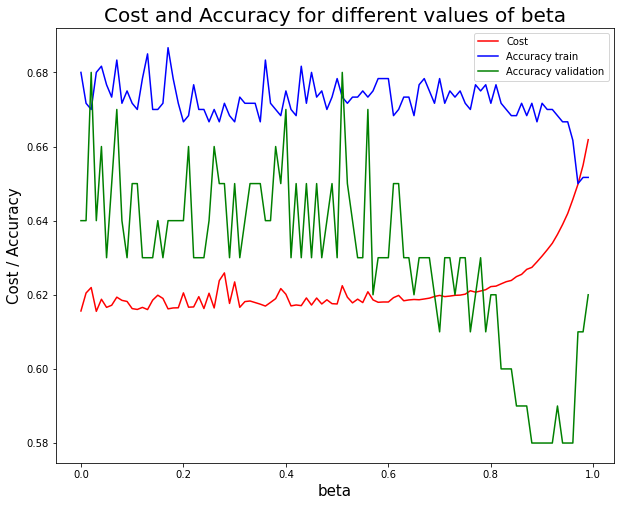

In [66]:
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_beta["beta"], results_beta["cost"], color="red", label="Cost")
plt.plot(results_beta["beta"], results_beta["acc_train"], color="blue", label="Accuracy train")
plt.plot(results_beta["beta"], results_beta["acc_val"], color="green", label="Accuracy validation")
plt.title("Cost and Accuracy for different values of beta", fontsize = 20) 
plt.xlabel("beta", fontsize=15)
plt.ylabel("Cost / Accuracy", fontsize=15)
plt.legend()

After we added momentum to the gradent descent implementation, we've tried multiple values of the momentum coefficient (from 0 to 1 with a step of 0.01). From the graph we can see that for values less than 0.2 the model his best results but it's difficult to chose the optimum value of the coefficient.

Text(0, 0.5, 'Time')

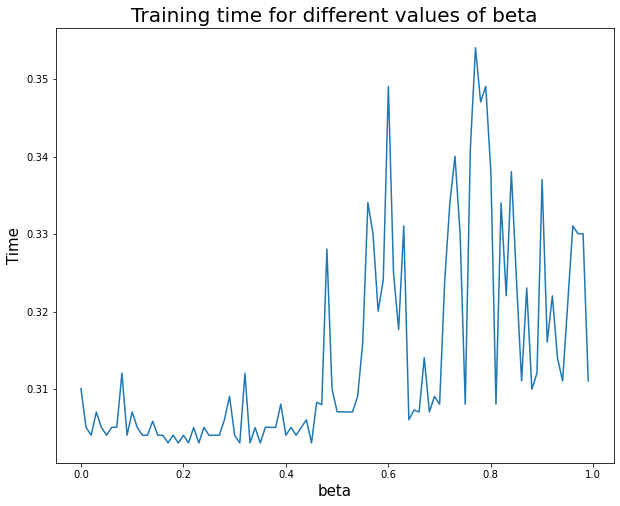

In [67]:
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_beta["beta"], results_beta["time"])
plt.title("Training time for different values of beta", fontsize = 20)
plt.xlabel("beta", fontsize=15)
plt.ylabel("Time", fontsize=15)

In this part of the exercise 

In [68]:
for i in range(len(results_beta["beta"])) :
    if results_beta["cost"][i] == min(results_beta["cost"]):
        print("Index:",i)        
        print("Accuracy train:",results_beta["acc_train"][i])
        print("Accuracy validation:",results_beta["acc_val"][i])
        print("Cost:",results_beta["cost"][i])        
        print("beta:",results_beta["beta"][i])       
        print("Time (s):",results_beta["time"][i])
        print ("-------------------------------------------------------")

Index: 3
Accuracy train: 0.68
Accuracy validation: 0.64
Cost: 0.6155301708701608
beta: 0.03
Time (s): 0.307039737701416
-------------------------------------------------------


### Question 4 :

In [88]:
results_batch = {"Batch_size" :[0, 1, 8, 16, 32, 64, 128, 256, 512],
               "acc_train" :[],
               "acc_val" :[],
               "cost" :[],
               "time" :[]
                }

batch = 4
for i in results_batch["Batch_size"]:
    start = time.time()
    model = LogisticRegression(add_bias=False, verbose=True, learning_rate=0.00014, max_iters=500, beta=0.07, batchSize=i)
    x11=[]
    x11,weight = model.fit(x_train,y_train)
    results_batch["time"].append((time.time() - start))
    yhat_train = x11.predict(x_train)
    yhat_val = x11.predict(x_validation)
    results_batch["acc_train"].append(accuracy(np.round(yhat_train),y_train))
    results_batch["acc_val"].append(accuracy(np.round(yhat_val),y_validation))
    results_batch["cost"].append(cost_fn(x_train, y_train, weight))
    print ("-------------------------------------------------------")


terminated after 500 iterations, with norm of the gradient equal to 0.19767543391230363
the weight found: [ 0.01430189  0.01232975 -0.02956635 -0.00230554  0.00147372 -0.00531549
  0.00031519  0.00379725]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 122.74933429315142
the weight found: [ 0.01537733  0.01377215 -0.04785275 -0.00719936  0.04706063 -0.00270348
  0.00047404  0.00855733]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 62.31010030849977
the weight found: [ 0.01360106  0.01826337 -0.02678681 -0.00097948  0.00291667 -0.00404631
  0.00041501  0.00682058]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 15.036350944966765
the weight found: [ 0.01422765  0.01170687 -0.03174791 -0.0044756   0.00196283 -0.00546823
  0.00029286  0.00428557]
----------------

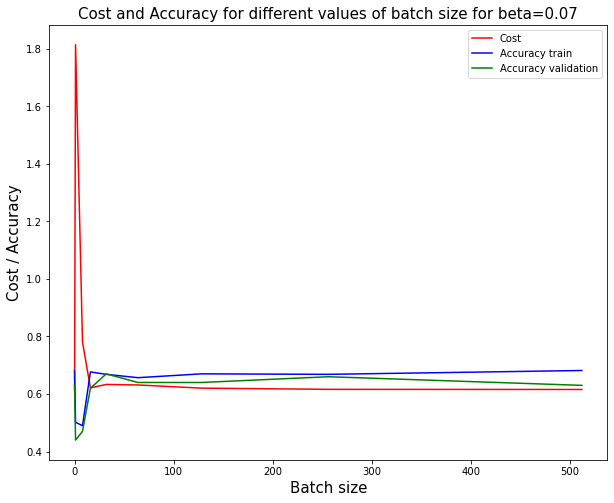

In [89]:
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_batch["Batch_size"], results_batch["cost"], color="red", label="Cost")
plt.plot(results_batch["Batch_size"], results_batch["acc_train"], color="blue", label="Accuracy train")
plt.plot(results_batch["Batch_size"], results_batch["acc_val"], color="green", label="Accuracy validation")
plt.title("Cost and Accuracy for different values of batch size for beta=0.07", fontsize = 15)
plt.xlabel("Batch size", fontsize=15)
plt.ylabel("Cost / Accuracy", fontsize=15)
plt.legend()

Text(0, 0.5, 'Time')

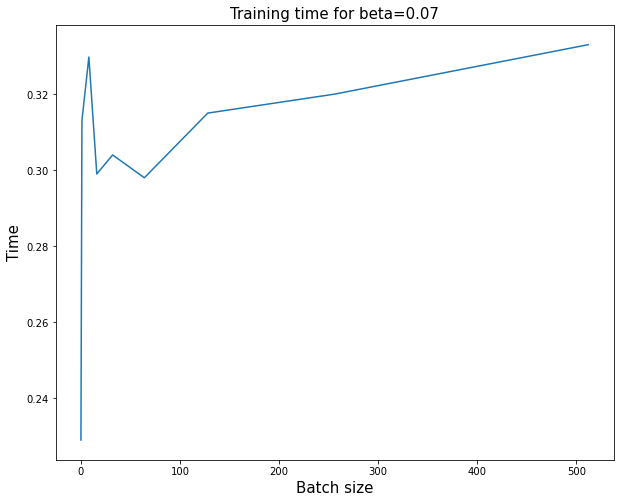

In [90]:
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_batch["Batch_size"], results_batch["time"])
plt.title("Training time for beta=0.07", fontsize = 15)
plt.xlabel("Batch size", fontsize=15)
plt.ylabel("Time", fontsize=15)

terminated after 500 iterations, with norm of the gradient equal to 0.17964249537447538
the weight found: [ 0.01242393  0.01231344 -0.02919112 -0.00264801  0.00148491 -0.00523336
  0.00026476  0.00341477]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 4.917058810787204
the weight found: [ 0.01164886  0.01261267 -0.06694086 -0.01658516  0.02731295 -0.02073881
  0.0002048  -0.01034655]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 39.75276702670259
the weight found: [ 0.01304326  0.01722359 -0.03097079 -0.00293884  0.00215875 -0.00515513
  0.00016051  0.00261142]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 26.64942374497112
the weight found: [ 0.01266343  0.01262645 -0.03031917 -0.00220558 -0.00107731 -0.00552057
  0.00022291  0.00430362]
------------------

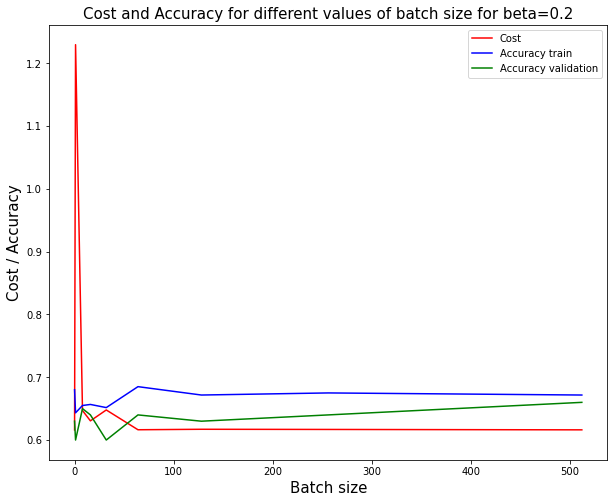

In [91]:
results_batch = {"Batch_size" :[0, 1, 8, 16, 32, 64, 128, 256, 512],
               "acc_train" :[],
               "acc_val" :[],
               "cost" :[],
               "time" :[]
                }

batch = 4
for i in results_batch["Batch_size"]:
    start = time.time()
    model = LogisticRegression(add_bias=False, verbose=True, learning_rate=0.00014, max_iters=500, beta=0.2, batchSize=i)
    x11=[]
    x11,weight = model.fit(x_train,y_train)
    results_batch["time"].append((time.time() - start))
    yhat_train = x11.predict(x_train)
    yhat_val = x11.predict(x_validation)
    results_batch["acc_train"].append(accuracy(np.round(yhat_train),y_train))
    results_batch["acc_val"].append(accuracy(np.round(yhat_val),y_validation))
    results_batch["cost"].append(cost_fn(x_train, y_train, weight))
    print ("-------------------------------------------------------")

    
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_batch["Batch_size"], results_batch["cost"], color="red", label="Cost")
plt.plot(results_batch["Batch_size"], results_batch["acc_train"], color="blue", label="Accuracy train")
plt.plot(results_batch["Batch_size"], results_batch["acc_val"], color="green", label="Accuracy validation")
plt.title("Cost and Accuracy for different values of batch size for beta=0.2", fontsize = 15)
plt.xlabel("Batch size", fontsize=15)
plt.ylabel("Cost / Accuracy", fontsize=15)
plt.legend()

Text(0, 0.5, 'Time')

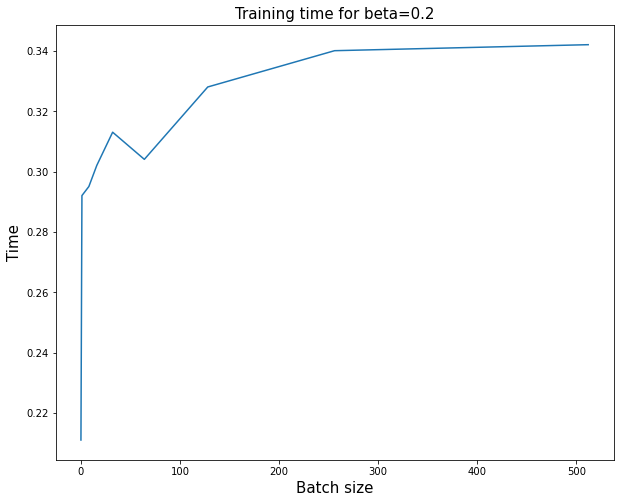

In [92]:
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_batch["Batch_size"], results_batch["time"])
plt.title("Training time for beta=0.2", fontsize = 15)
plt.xlabel("Batch size", fontsize=15)
plt.ylabel("Time", fontsize=15)

terminated after 500 iterations, with norm of the gradient equal to 0.14357349497781938
the weight found: [ 0.00789336  0.01193899 -0.02742692 -0.00373252  0.00153966 -0.00496146
  0.00014823  0.00199527]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 17.913644913036322
the weight found: [ 0.00706546  0.0184716  -0.0436004  -0.0083819  -0.00483037 -0.00709747
  0.00028834 -0.00344089]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 23.46273207309689
the weight found: [ 0.00811845  0.01197262 -0.027023   -0.00350054  0.00220778 -0.00414567
  0.00018457  0.00311484]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 12.360423523819465
the weight found: [ 0.00793616  0.01215451 -0.02824345 -0.00455477  0.00112556 -0.00512999
  0.00011709  0.00116325]
----------------

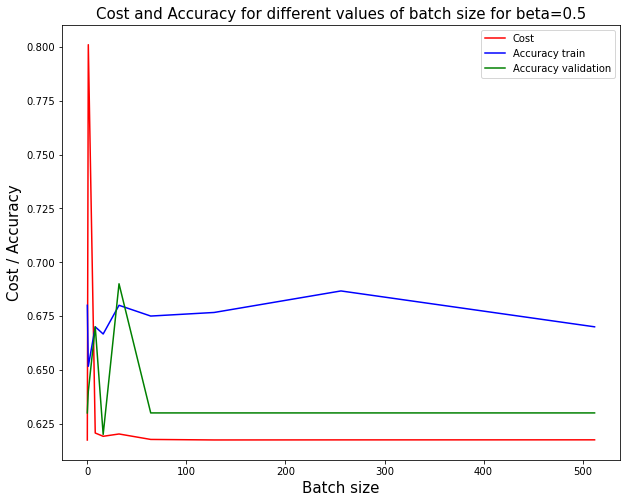

In [93]:
results_batch = {"Batch_size" :[0, 1, 8, 16, 32, 64, 128, 256, 512],
               "acc_train" :[],
               "acc_val" :[],
               "cost" :[],
               "time" :[]
                }

batch = 4
for i in results_batch["Batch_size"]:
    start = time.time()
    model = LogisticRegression(add_bias=False, verbose=True, learning_rate=0.00014, max_iters=500, beta=0.5, batchSize=i)
    x11=[]
    x11,weight = model.fit(x_train,y_train)
    results_batch["time"].append((time.time() - start))
    yhat_train = x11.predict(x_train)
    yhat_val = x11.predict(x_validation)
    results_batch["acc_train"].append(accuracy(np.round(yhat_train),y_train))
    results_batch["acc_val"].append(accuracy(np.round(yhat_val),y_validation))
    results_batch["cost"].append(cost_fn(x_train, y_train, weight))
    print ("-------------------------------------------------------")

    
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_batch["Batch_size"], results_batch["cost"], color="red", label="Cost")
plt.plot(results_batch["Batch_size"], results_batch["acc_train"], color="blue", label="Accuracy train")
plt.plot(results_batch["Batch_size"], results_batch["acc_val"], color="green", label="Accuracy validation")
plt.title("Cost and Accuracy for different values of batch size for beta=0.5", fontsize = 15)
plt.xlabel("Batch size", fontsize=15)
plt.ylabel("Cost / Accuracy", fontsize=15)
plt.legend()

Text(0, 0.5, 'Time')

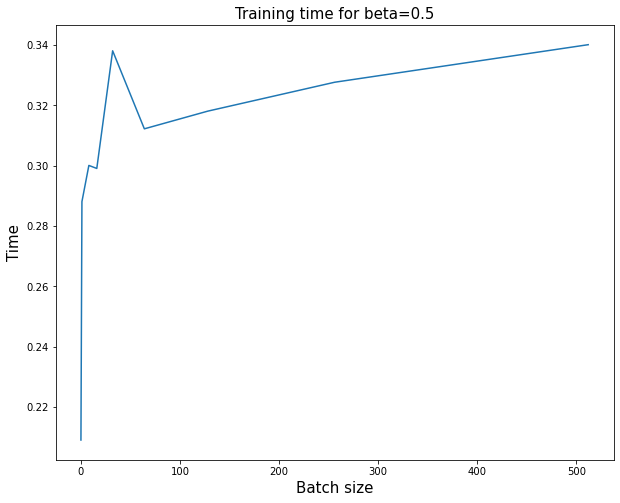

In [94]:
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_batch["Batch_size"], results_batch["time"])
plt.title("Training time for beta=0.5", fontsize = 15)
plt.xlabel("Batch size", fontsize=15)
plt.ylabel("Time", fontsize=15)

terminated after 500 iterations, with norm of the gradient equal to 0.1551490975975068
the weight found: [ 3.08671001e-03  8.83102412e-03 -2.08851883e-02 -4.40598298e-03
  1.68940256e-03 -3.99086209e-03  3.69940646e-05 -1.28309166e-04]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 28.028049756535726
the weight found: [ 2.82182400e-03  9.25568515e-03 -1.85052360e-02 -4.88999890e-03
  6.32049073e-03 -3.63783129e-03  4.71775470e-05 -1.63159483e-03]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 7.487841827839346
the weight found: [ 3.01847779e-03  7.25381281e-03 -2.18986140e-02 -5.18945444e-03
  5.37957088e-04 -4.24929214e-03  2.08448110e-05 -1.56760388e-04]
-------------------------------------------------------
terminated after 500 iterations, with norm of the gradient equal to 2.1992058136380663
the weight found: [ 3.02378206e-03  8.

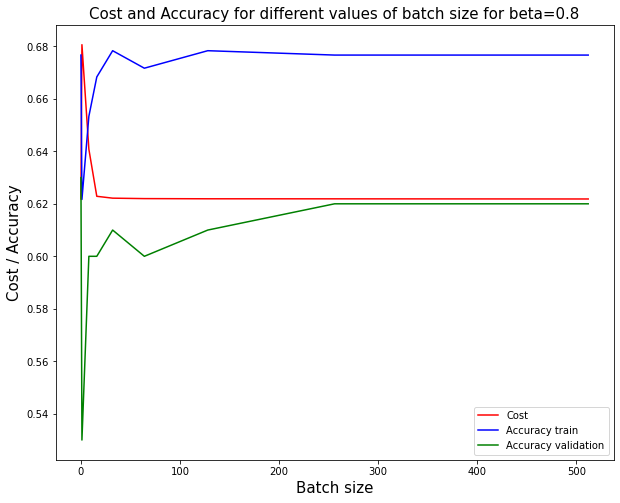

In [95]:
results_batch = {"Batch_size" :[0, 1, 8, 16, 32, 64, 128, 256, 512],
               "acc_train" :[],
               "acc_val" :[],
               "cost" :[],
               "time" :[]
                }

batch = 4
for i in results_batch["Batch_size"]:
    start = time.time()
    model = LogisticRegression(add_bias=False, verbose=True, learning_rate=0.00014, max_iters=500, beta=0.8, batchSize=i)
    x11=[]
    x11,weight = model.fit(x_train,y_train)
    results_batch["time"].append((time.time() - start))
    yhat_train = x11.predict(x_train)
    yhat_val = x11.predict(x_validation)
    results_batch["acc_train"].append(accuracy(np.round(yhat_train),y_train))
    results_batch["acc_val"].append(accuracy(np.round(yhat_val),y_validation))
    results_batch["cost"].append(cost_fn(x_train, y_train, weight))
    print ("-------------------------------------------------------")

    
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_batch["Batch_size"], results_batch["cost"], color="red", label="Cost")
plt.plot(results_batch["Batch_size"], results_batch["acc_train"], color="blue", label="Accuracy train")
plt.plot(results_batch["Batch_size"], results_batch["acc_val"], color="green", label="Accuracy validation")
plt.title("Cost and Accuracy for different values of batch size for beta=0.8", fontsize = 15)
plt.xlabel("Batch size", fontsize=15)
plt.ylabel("Cost / Accuracy", fontsize=15)
plt.legend()

Text(0, 0.5, 'Time')

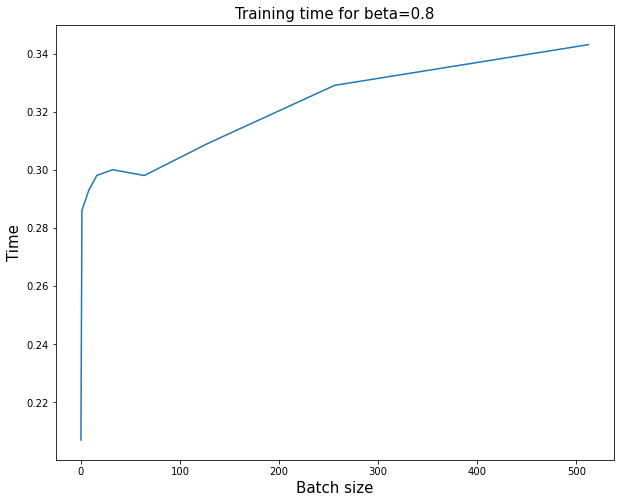

In [96]:
f,ax = plt.subplots(figsize = (10, 8))
plt.plot(results_batch["Batch_size"], results_batch["time"])
plt.title("Training time for beta=0.8", fontsize = 15)
plt.xlabel("Batch size", fontsize=15)
plt.ylabel("Time", fontsize=15)

In this part of the exercise, we've run the model with a learning rate = 0.00014, max iterations = 500, for multiple value of batch size and beta. From the results we can say that the model converge to a solution more for smaller values of beta and batch size, and we also confirm that the model start to give us bad results for beta value equal or more than 0.8 and large batch size values.

# Part 2

## Loading Datasets
Reading from training, validation and test csv files

In [2]:
fake_news_train = pd.read_csv('.\\data_A2\\fake_news\\fake_news_train.csv')
fake_news_validation = pd.read_csv('.\\data_A2\\fake_news\\fake_news_val.csv')
fake_news_test = pd.read_csv('.\\data_A2\\fake_news\\fake_news_test.csv')

fake_news_train.head()

text  label
0  Indian fruit is so important to so many people...      0
1  FORT WORTH, Texas — Urú Inc. will hold a confe...      0
2  With three of the four new carriers, the Niger...      0
3  Let's start with the classic annual dividend r...      0
4  Following are some of the major events to have...      1

## Preprocessing
Splitting the 3 datasets into x (input data) and y (target values)

In [3]:
# Shuffling
fake_news_train = shuffle(fake_news_train)
fake_news_train = fake_news_train.reset_index(drop=True)
fake_news_validation = shuffle(fake_news_validation)
fake_news_validation = fake_news_validation.reset_index(drop=True)
fake_news_test = shuffle(fake_news_test)
fake_news_test = fake_news_test.reset_index(drop=True)

# Lowercase all the text
fake_news_train['text'] = fake_news_train['text'].apply(lambda x: x.lower())
fake_news_validation['text'] = fake_news_validation['text'].apply(lambda x: x.lower())
fake_news_test['text'] = fake_news_test['text'].apply(lambda x: x.lower())


# Training
x_fake_news_train = fake_news_train['text']
y_fake_news_train = fake_news_train['label']

# Validation
x_fake_news_validation = fake_news_validation['text']
y_fake_news_validation = fake_news_validation['label']

# Test
x_fake_news_test = fake_news_test['text']
y_fake_news_test = fake_news_test['label']

## Tokenizing

We can use the basic tokenizer from ntltk.tokenize (word_tokenize) OR a custom one, that removes punctuation

In [13]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

# x_fake_news_train.head
def tokenize_nltk(text):
    """
    This tokenizer uses the default function of nltk package (word_tokenize) to tokenize the text.(https://www.nltk.org/api/nltk.html) 
    """
    # return a list of tokens
    tokens = nltk.tokenize.word_tokenize(text.lower())
    return tokens

def tokenize_space_punk(text):
    """
    This tokenizer replaces punctuation to spaces and then tokenizes the tokens that are separated by whitespace (space, tab, newline).
    """
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text.lower())
    return tokens

## Removing Stop Words

Removing stop words can help our classifier not use words without much significance

In [14]:
from nltk.corpus import stopwords
nltk.download('stopwords')

def filter_tokens(tokens):
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in tokens if not w in stop_words] 
    return filtered_sentence

# x_fake_news_train.apply(filter_tokens)
# x_fake_news_validation.apply(filter_tokens)
# x_fake_news_test.apply(filter_tokens)

[nltk_data] Downloading package stopwords to C:\Users\Saad
[nltk_data]     Benslimane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Stemming

Another preprocessing technique that we can use is to group related words into their word stem (a word that is the root of all these words). This technique is called stemming

In [15]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 


def stem_tokens(tokens):
    stemmer = SnowballStemmer("english")
    stemmed_sentence = [stemmer.stem(w) for w in tokens]
    return stemmed_sentence

# x_fake_news_train.apply(stem_tokens)
# x_fake_news_validation.apply(stem_tokens)
# x_fake_news_test.apply(stem_tokens)

## Lemmatization

An alternate preprocessing technique is lemmatization, which consists of the basic functionality of stemming, with the added functionality of knowing the contex of words. For example lemmmatization would group "better" and "good", while stemming would not. Lemmatization usually has higher accuracy, but is slower. The class we will create will also tokenize the data without needing a separate method.

In [16]:
import nltk
nltk.download('wordnet')

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# A method to tokenize and stem text, that we can potentially pass later to CountVectorizer
def tokenize_and_stem(text):
    tokenized = tokenize_nltk(text)
    return stem_tokens(tokenized)


[nltk_data] Downloading package wordnet to C:\Users\Saad
[nltk_data]     Benslimane\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Bags of words

Intuitive first way to turn text into numerical feature vectors. Works as follows:

  1. Assign a fixed integer id to each word occurring in any document of the training set (for instance by building a dictionary from words to integer indices).
  2. For each document #i, count the number of occurrences of each word w and store it in X[i, j] as the value of feature #j where j is the index of word w in the dictionary

Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, which builds a dictionary of features and transforms documents to feature vectors:

In [17]:
count_vect = CountVectorizer(tokenizer=tokenize_and_stem, stop_words='english')
X_train_counts = count_vect.fit_transform(x_fake_news_train)
X_train_counts.shape

(20000, 175226)

In [18]:
count_vect.vocabulary_.get(u'algorithm')

27676

## Occurences to frequencies

Occurrence is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics. -> Frequencies is more useful

-> divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

-> we will also downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”. Both tf and tf–idf can be computed as follows using TfidfTransformer:

In [19]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(20000, 175226)

# Classification using Logistic Regression

## Pipeline

We combine many of the above steps

Piepeline : Compound classifier that simplifies above steps of vectorizer => transformer => classifier

- We will use LogicsticRegressionCV to automatically tune the C parameter, and to classify future data

- tokenizer: We will override the default word tokenizer with the lemmatization class we created

- ngram_range: "The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted. All values of n such such that min_n <= n <= max_n will be used." For more information, we will use unigrams and bigrams (ngram_range=(1,2))

- stop_words: If set to 'english', will ignore stop words. We found that this does not actually improve accuracy for this dataset.

- solver: The solver for LogisticRegressionCV. Since this is a large dataset, we will use sag.

At the end of the notebook there will be a grid search that concretely justifies our choices of hyperparameters. 

In [20]:
text_clf = Pipeline([
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('lr',LogisticRegressionCV(random_state=0, n_jobs=-1, verbose=2, solver='sag')),
])

## Fitting To Training Data

In [21]:
text_clf = text_clf.fit(x_fake_news_train, y_fake_news_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


rescaling...
rescaling...rescaling...

rescaling...
rescaling...rescaling...rescaling...


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...rescaling...


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...rescaling...


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...


rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling..

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...rescaling...


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 8 epochs took 33 sec

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.2min finished


max_iter reached after 65 seconds


## Training Accuracy

In [22]:
training_predicted = text_clf.predict(x_fake_news_train)
np.mean(training_predicted == y_fake_news_train)

1.0

### Despite using cross validation to pick best values of C, we can see that our classifier is overfitting (1.0 accuracy when predicting on training set) 

## Evaluation of the performance on the test set

After fitting on training data. We can treate the validation set like a second test set.

In [23]:
# Accuracy of testing on validation set
validation_predicted = text_clf.predict(x_fake_news_validation)
np.mean(validation_predicted == y_fake_news_validation)

0.7975

In [24]:
# Accuracy of testing on test set
test_predicted = text_clf.predict(x_fake_news_test)
np.mean(test_predicted == y_fake_news_test)

0.787

# Grid Search (If time permits... (VERY LENGTHY))

## Tuning Hyperparams With Grid Search + Fitting To Training Data

Instead of tweaking the parameters of the various components of the chain, it is possible to run an exhaustive search of the best parameters on a grid of possible values. Below is a very exhaustive version, that is somewhat unrealistic to run. To pick "optimal" hyperparameter values that we chose above, multiple less exhaustive searches were made. We will demonstrate the code that would follow for grid search.

In [ ]:
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'tfidf__use_idf': (True, False),
    'lr__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'lr__penalty': ['l1', 'l2', 'elasticnet'],
    'vect__tokenizer': [LemmaTokenizer(), None],
    'vect__stop_words': ['english', None],
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, verbose=2) # 5 fold cross validation for each parameter vector
gs_clf = gs_clf.fit(x_fake_news_train, y_fake_news_train)

## Training Accuracy After Grid Search

In [ ]:
training_predicted = gs_clf.predict(x_fake_news_train)
np.mean(training_predicted == y_fake_news_train)

## Results of Grid Search

The object’s best_score_ and best_params_ attributes store the best mean score and the parameters setting corresponding to that score:

In [ ]:
gs_clf.best_score_

In [ ]:
print("Best Param Choices")
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

### Table Of Results

In [ ]:
pd.concat([pd.DataFrame(gs_clf.cv_results_["params"]),pd.DataFrame(gs_clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

## Evaluation of the performance on the test set
After grid search and fitting on training data. We can treate the validation set like another test set.

In [ ]:
validation_predicted = gs_clf.predict(x_fake_news_validation)
np.mean(validation_predicted == y_fake_news_validation)

In [ ]:
test_predicted = gs_clf.predict(x_fake_news_test)
np.mean(test_predicted == y_fake_news_test)